<a href="https://colab.research.google.com/github/mihaijulien/Behavioral-Cloning/blob/master/Behavioral_Cloning_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/mihaijulien/Behavioral-Cloning

In [75]:
ls Behavioral-Cloning/dataset

driving_log.csv  IMG/


In [0]:
!pip3 install imgaug

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath
import pandas as pd
import numpy as np
import random

In [76]:
datadir = 'Behavioral-Cloning/dataset/'
columns = ['center','left','right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None) # set option to not limit the column width when displaying the head() next
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_735.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_735.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_735.jpg,0.0,0.0,0,9.144389e-06
1,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_816.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_816.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_816.jpg,0.0,0.0,0,7.870705e-07
2,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_907.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_907.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_907.jpg,0.0,0.0,0,7.281133e-06
3,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_16_985.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_16_985.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_16_985.jpg,0.0,0.0,0,6.724605e-06
4,D:\Behavioral-Cloning\dataset\IMG\center_2020_06_05_16_06_17_057.jpg,D:\Behavioral-Cloning\dataset\IMG\left_2020_06_05_16_06_17_057.jpg,D:\Behavioral-Cloning\dataset\IMG\right_2020_06_05_16_06_17_057.jpg,0.0,0.0,0,8.078994e-06


In [0]:
def leaf_path(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(leaf_path)
data['right'] = data['right'].apply(leaf_path)
data['left'] = data['left'].apply(leaf_path)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


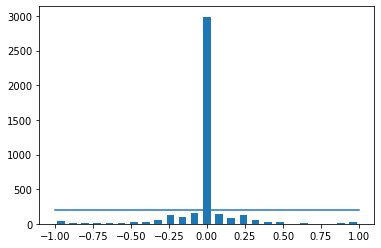

In [0]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2790
remaining: 1263


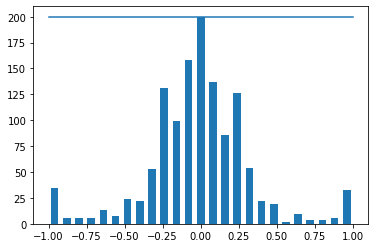

In [0]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(image_paths)
print(steerings)

center      center_2018_07_16_17_11_44_413.jpg
left          left_2018_07_16_17_11_44_413.jpg
right        right_2018_07_16_17_11_44_413.jpg
steering                                 -0.05
throttle                              0.642727
reverse                                      0
speed                                  1.43401
Name: 12, dtype: object
['track/IMG/center_2018_07_16_17_11_43_792.jpg'
 'track/IMG/left_2018_07_16_17_11_43_792.jpg'
 'track/IMG/right_2018_07_16_17_11_43_792.jpg' ...
 'track/IMG/center_2018_07_16_17_16_30_771.jpg'
 'track/IMG/left_2018_07_16_17_16_30_771.jpg'
 'track/IMG/right_2018_07_16_17_16_30_771.jpg']
[ 0.    0.15 -0.15 ...  0.    0.15 -0.15]


Training samples: 3031 
 Test samples: 758


Text(0.5, 1.0, 'Test set')

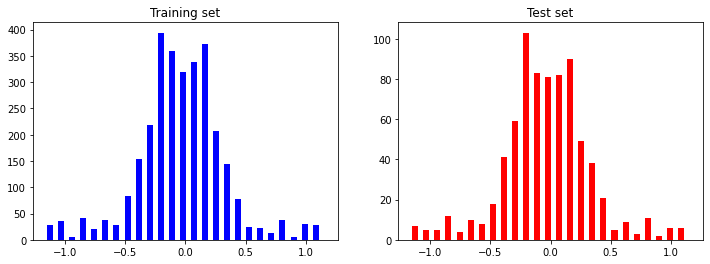

In [0]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2)
print('Training samples: {} \n Test samples: {}'.format(len(X_train), len(X_test)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_test, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Test set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

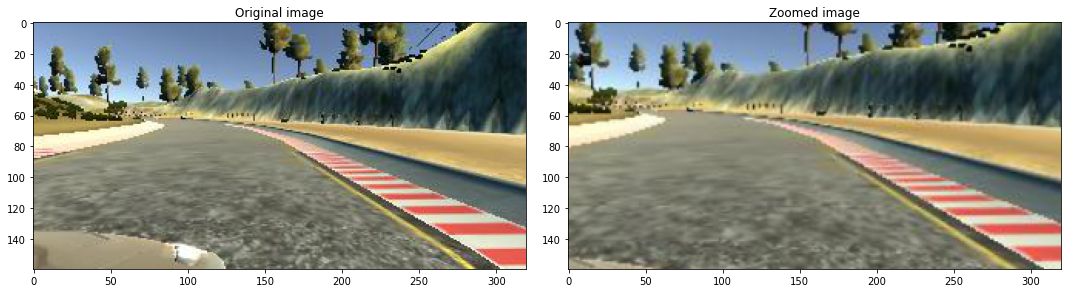

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axis = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(zoomed_image)
axis[1].set_title('Zoomed image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

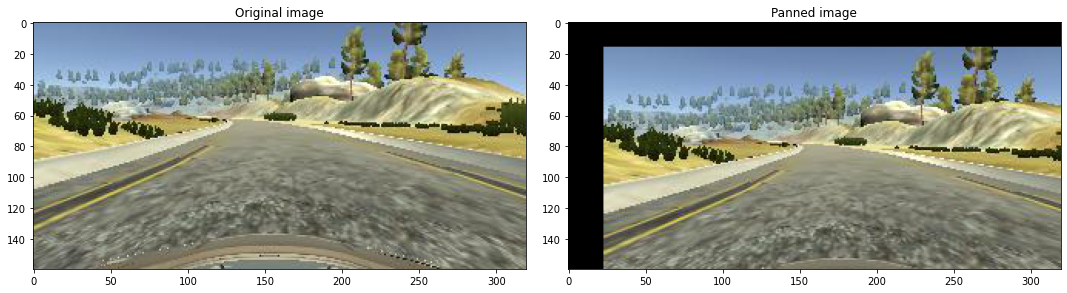

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axis = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(panned_image)
axis[1].set_title('Panned image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered image')

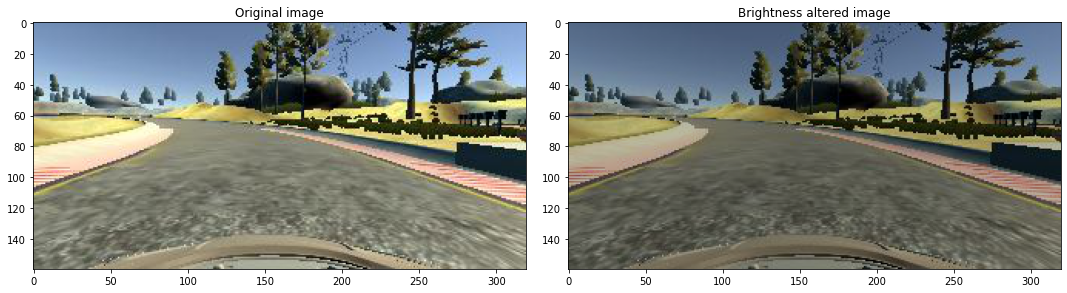

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axis = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(brightness_altered_image)
axis[1].set_title('Brightness altered image')

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2')

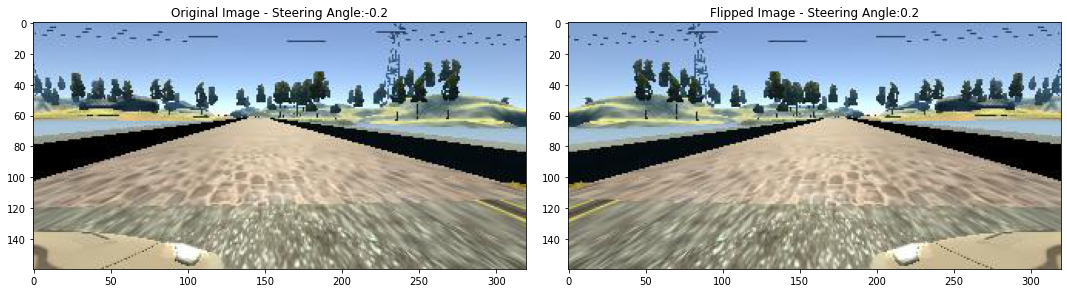

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def img_preprocess(img):
  img = img[60:135,:,:]  #crop out unnecessary background leaving only the road
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img, (200, 66))
  return img

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fix, axis = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title("Original image")
axis[1].imshow(preprocessed_image)
axis[1].set_title("Preprocessed image")

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(X_test, y_test, 1, 0))

Text(0.5, 1.0, 'Test Image')

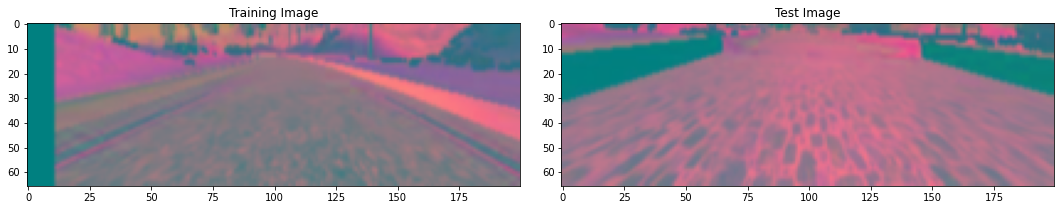

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_test_gen[0])
axs[1].set_title('Test Image')

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
    model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))  
    optimizer= Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [0]:
model = nvidia_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [70]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_test, y_test, 100, 0),
                                  validation_steps=300,
                                  verbose=1,
                                  shuffle = 1)
                            

Epoch 1/10
300/300 [==============================] - 456s 2s/step - loss: 0.4187 - val_loss: 0.1557
Epoch 2/10
300/300 [==============================] - 452s 2s/step - loss: 0.1056 - val_loss: 0.1485
Epoch 3/10
300/300 [==============================] - 451s 2s/step - loss: 0.0906 - val_loss: 0.0565
Epoch 4/10
300/300 [==============================] - 464s 2s/step - loss: 0.0848 - val_loss: 0.0551
Epoch 5/10
300/300 [==============================] - 461s 2s/step - loss: 0.0759 - val_loss: 0.0494
Epoch 6/10
300/300 [==============================] - 455s 2s/step - loss: 0.0678 - val_loss: 0.0576
Epoch 7/10
300/300 [==============================] - 457s 2s/step - loss: 0.0649 - val_loss: 0.0353
Epoch 8/10
300/300 [==============================] - 454s 2s/step - loss: 0.0639 - val_loss: 0.0368
Epoch 9/10
300/300 [==============================] - 454s 2s/step - loss: 0.0589 - val_loss: 0.0522
Epoch 10/10
300/300 [==============================] - 459s 2s/step - loss: 0.0572 - val_lo

Text(0.5, 0, 'Epochs')

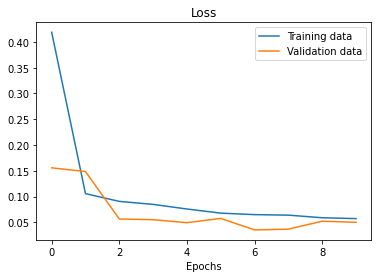

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training data', 'Validation data'])
plt.title('Loss')
plt.xlabel('Epochs')

In [0]:
model.save('model.h5')
from google.colab import files

files.download('model.h5')